In [1225]:
# import required libraries
import pandas as pd
import yfinance as yf
import numpy as np
import math 

In [1241]:
# input ticker and parameters
ticker = 'TQQQ'
start_date = '2010-01-01'
end_date = '2022-01-01'
df = yf.download(ticker, start_date, end_date, threads= False)
df = df.reset_index()
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-11,0.813750,0.869792,0.811146,0.865104,0.862942,1728000
1,2010-02-12,0.841563,0.876146,0.836667,0.868646,0.866475,4300800
2,2010-02-16,0.889063,0.904375,0.875104,0.902292,0.900037,4809600
3,2010-02-17,0.914375,0.917813,0.900625,0.917604,0.915311,9590400
4,2010-02-18,0.916667,0.940521,0.911146,0.935000,0.932663,19430400


In [1242]:
# parameter setup (default values in the original indicator)
length = 20
mult = 2
length_KC = 20
mult_KC = 1.5


# calculate Bollinger Bands
# moving average
m_avg = df['Close'].rolling(window=length).mean()
# standard deviation
m_std = df['Close'].rolling(window=length).std(ddof=0)
# upper Bollinger Bands
df['upper_BB'] = m_avg + mult * m_std
# lower Bollinger Bands 
df['lower_BB'] = m_avg - mult * m_std


# calculate Keltner Channel
# first we need to calculate True Range
df['tr0'] = abs(df["High"] - df["Low"])
df['tr1'] = abs(df["High"] - df["Close"].shift())
df['tr2'] = abs(df["Low"] - df["Close"].shift())
df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR
range_ma = df['tr'].rolling(window=length_KC).mean()
# upper Keltner Channel
df['upper_KC'] = m_avg + range_ma * mult_KC
# lower Keltner Channel
df['lower_KC'] = m_avg - range_ma * mult_KC


# calculate momentum value***
highest = df['High'].rolling(window = length_KC).max()
lowest = df['Low'].rolling(window = length_KC).min()
m1 = (highest + lowest) / 2
df['value'] = (df['Close'] - (m1 + m_avg)/2)
fit_y = np.array(range(0,length_KC))
df['value'] = df['value'].rolling(window = length_KC).apply(lambda x : np.polyfit(fit_y, x, 1)[0] * (length_KC-1) + np.polyfit(fit_y, x, 1)[1], raw=True)

In [1243]:
# add the change of momentum value***
df['change'] = df['value'].diff()

In [1244]:
# entry point for long TQQQ:
# when value increases in the negative range (eg. from -10 to -9)
df['enter1_long'] = (df['change'] > 0) & (df['value'] < 0)
# exit point for long TQQQ:
# 1. when value decreases from positive to negative
df['exit1_long'] = (df['change'] < 0) & (df['value'].shift() > 0) & (df['value'] < 0)
# 2. when value decreases in the negative range (eg. from -9 to -10)
df['exit2_long'] = (df['change'] < 0) & (df['value'].shift() < 0 ) & (df['value'] < 0)


# entry point for long SQQQ:
# 1. when value decreases from positive to negative
df['enter1_short'] = df['exit1_long']
# 2. when value decreases in the nagtive range
df['enter2_short'] = (df['change'] < 0) & (df['value'] < 0)
# exit point for long SQQQ:
df['exit1_short'] = (df['change'] > 0) & (df['value'] < 0)

In [1245]:
# simplification
df['buy_long'] = (df['enter1_long'].shift() == False) & (df['enter1_long'] == True)
df['close_long'] = (df['exit1_long'].shift() == False) & (df['exit1_long'] == True) | (df['exit2_long'].shift() == False) & (df['exit2_long'] == True)


df['buy_short'] = (df['enter1_short'].shift() == False) & (df['enter1_short'] == True) | (df['enter2_short'].shift() == False) & (df['enter2_short'] == True)
df['close_short'] = (df['exit1_short'].shift() == False) & (df['exit1_short'] == True) 

In [1246]:
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,upper_BB,lower_BB,tr0,...,enter1_long,exit1_long,exit2_long,enter1_short,enter2_short,exit1_short,buy_long,close_long,buy_short,close_short
39,2010-04-09,1.200417,1.220938,1.191146,1.218021,1.214977,14524800,1.222061,1.082887,0.029792,...,False,False,False,False,False,False,False,False,False,False
40,2010-04-12,1.222188,1.232292,1.214167,1.222917,1.219861,12201600,1.230071,1.087336,0.018125,...,False,False,False,False,False,False,False,False,False,False
41,2010-04-13,1.218958,1.243333,1.207917,1.241354,1.238252,16809600,1.239127,1.093321,0.035416,...,False,False,False,False,False,False,False,False,False,False
42,2010-04-14,1.259063,1.286146,1.256458,1.285104,1.281893,15273600,1.260005,1.089797,0.029688,...,False,False,False,False,False,False,False,False,False,False
43,2010-04-15,1.283750,1.307083,1.282604,1.302292,1.299038,11443200,1.281696,1.086408,0.024479,...,False,False,False,False,False,False,False,False,False,False


In [1247]:
capital = 1000
stop_loss_short = -0.05
take_profit_short = 0.06 # for shorting
stop_loss_long = -0.20

In [1258]:
nav = capital
trades = []

for i in range(len(df)):
    if df['buy_long'].iloc[i] == True:
        open_price = df['Open'].iloc[i + 1]
        open_date = df['Date'].iloc[i + 1]

        for j in range(i + 1, len(df)):
            
            current_price = df['Open'].iloc[j]
            change = current_price - open_price
            change_per = round(change / open_price, 2)
            
#             if(change_per < stop_loss_long):
#                 close_price = df['Open'].iloc[j + 1]
#                 close_date = df['Date'].iloc[j + 1]
#                 change = close_price - open_price
#                 change_per = round(change / open_price, 2)     
#                 nav = round(nav * (1 + change_per), 2)
                
#                 trade = []
#                 trade.append("LONG")
#                 trade.append("STOPLOSS")
#                 trade.append(nav)
#                 trade.append(change_per)
#                 trade.append(nav)
#                 trade.append(open_date)
#                 trade.append(close_date)
#                 trades.append(trade)
#                 break
                
            if df['close_long'].iloc[j] == True and j != (len(df) - 1):
            

                
                close_price = df['Open'].iloc[j + 1]
                close_date = df['Date'].iloc[j + 1]
                change = close_price - open_price
                change_per = round(change / open_price, 2)     
                nav = round(nav * (1 + change_per), 2)
                
                trade = []
                trade.append("LONG")
                trade.append("NORMAL")
                trade.append(nav)
                trade.append(change_per)
                trade.append(nav)
                trade.append(open_date)
                trade.append(close_date)
                trades.append(trade)
                break
                
    if df['buy_short'].iloc[i] == True:
        open_price = df['Open'].iloc[i + 1]
        open_date = df['Date'].iloc[i + 1]
        
        for j in range(i + 1, len(df)):
            current_price = df['Open'].iloc[j]
            change = open_price - current_price
            change_per = round(change / open_price, 2)

            if change_per < stop_loss_short  and j != (len(df) - 1):
   
                close_price = df['Open'].iloc[j + 1]
                close_date = df['Date'].iloc[j+1]
                change = open_price - close_price
                change_per = round(change / open_price, 2)
                nav = round(nav * (1 + change_per), 2)
                
                trade = []
                trade.append("SHORT")
                trade.append("STOPLOSS")
                trade.append(nav)   
                trade.append(change_per)
                trade.append(nav)
                trade.append(open_date)
                trade.append(close_date)
                trades.append(trade)
                break
                
            if change_per > take_profit_short  and j != (len(df) - 1):
                close_price = df['Open'].iloc[j + 1]
                close_date = df['Date'].iloc[j + 1]
                change = open_price - close_price
                change_per = round(change / open_price, 2)
                nav = round(nav * (1 + change_per), 2)
                
                trade = []
                trade.append("SHORT")
                trade.append("TAKEPROFIT")
                trade.append(nav)   
                trade.append(change_per)
                trade.append(nav)
                trade.append(open_date)
                trade.append(close_date)
                trades.append(trade)
                break                
           
            
            if df['close_short'].iloc[j] == True  and j != (len(df) - 1):
   
                
                close_price = df['Open'].iloc[j + 1]
                close_date = df['Date'].iloc[j+1]
                change = open_price - close_price
                change_per = round(change / open_price, 2)
                nav = round(nav * (1 + change_per), 2)
                
                trade = []
                trade.append("SHORT")
                trade.append("NORMAL")
                trade.append(nav)   
                trade.append(change_per)
                trade.append(nav)
                trade.append(open_date)
                trade.append(close_date)
                trades.append(trade)
                break
           
    

In [1259]:
# for each in range(len(trades)):
#     if(trades[each][0] == 'LONG'):
#         print(trades[each])

In [1260]:
# for each in range(len(trades)):
#     if(trades[each][0] == 'SHORT'):
#         print(trades[each])

In [1261]:
for each in range(len(trades)):
    if(trades[each][3] < 0):
        print(trades[each])

['LONG', 'NORMAL', 946.4, -0.09, 946.4, Timestamp('2010-05-13 00:00:00'), Timestamp('2010-05-17 00:00:00')]
['LONG', 'NORMAL', 1087.88, -0.05, 1087.88, Timestamp('2010-05-28 00:00:00'), Timestamp('2010-06-07 00:00:00')]
['LONG', 'NORMAL', 1005.2, -0.12, 1005.2, Timestamp('2010-06-11 00:00:00'), Timestamp('2010-07-01 00:00:00')]
['SHORT', 'STOPLOSS', 914.73, -0.09, 914.73, Timestamp('2010-07-01 00:00:00'), Timestamp('2010-07-09 00:00:00')]
['LONG', 'NORMAL', 905.58, -0.01, 905.58, Timestamp('2010-07-13 00:00:00'), Timestamp('2010-08-17 00:00:00')]
['SHORT', 'NORMAL', 1522.39, -0.05, 1522.39, Timestamp('2010-11-19 00:00:00'), Timestamp('2010-12-02 00:00:00')]
['SHORT', 'STOPLOSS', 1698.99, -0.07, 1698.99, Timestamp('2011-03-02 00:00:00'), Timestamp('2011-03-07 00:00:00')]
['LONG', 'NORMAL', 1987.21, -0.05, 1987.21, Timestamp('2011-06-01 00:00:00'), Timestamp('2011-06-02 00:00:00')]
['LONG', 'NORMAL', 2101.08, -0.03, 2101.08, Timestamp('2011-06-15 00:00:00'), Timestamp('2011-06-16 00:00:0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


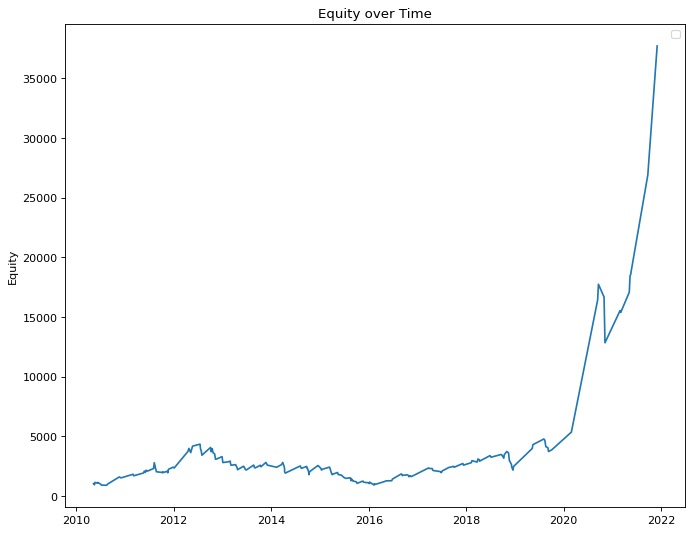

In [1262]:
import matplotlib.pyplot as plt


equity_value = []
date = []
for i in range(len(trades)): 
    equity_value.append(trades[i][4])
    date.append(trades[i][6])


plt.figure(figsize=(10, 8), dpi=80)
plt.ylabel("Equity")
plt.title("Equity over Time")
plt.plot(date, equity_value)
plt.legend()
plt.show()


In [1263]:
first_date = trades[0][5]
last_date = trades[len(trades)-1][6]
returns = nav - capital
returns_per = round(returns / capital * 100, 1)
years = (last_date - first_date).days/365
annualized_returns = round((pow((returns / capital),1/years)-1)*100,2)

print("========== performance ==========")
print("ticker: ", ticker)
print("start date:", first_date.strftime('%Y-%m-%d'))
print("end date:", last_date.strftime('%Y-%m-%d'))
print("start amount: $", capital)
print("final amount: $", nav)
print("returns: $", returns)
print("returns_per:", returns_per, "%")
print("annualized returns:", annualized_returns, "%")
print("=================================")

========== performance ==========
ticker:  TQQQ
start date: 2010-05-06
end date: 2021-12-01
start amount: $ 1000
final amount: $ 37716.13
returns: $ 36716.13
returns_per: 3671.6 %
annualized returns: 36.5 %


In [1264]:
win_count = 0
lose_count = 0
long_win_count = 0
long_lose_count = 0
short_win_count = 0
short_lose_count = 0

for each in range(len(trades)):
    if(trades[each][3] > 0):
        win_count += 1
        if(trades[each][0] == 'LONG'):
            long_win_count += 1
        else:
            short_win_count += 1
    else:
        lose_count += 1
        if(trades[each][0] == 'LONG'):
            long_lose_count += 1
        else:
            short_lose_count += 1
        
win_rate = round(win_count / (win_count + lose_count) * 100, 1)
long_win_rate = round(long_win_count / (long_win_count + long_lose_count) * 100, 1)
short_win_rate = round(short_win_count / (short_win_count + short_lose_count) * 100, 1)

print("========== overall trades ==========")
print("win count:", win_count)
print("lose count:", lose_count)
print("win rate:", win_rate, "%")

print("========== long trades ==========")
print("win count:", long_win_count)
print("lose count:", long_lose_count)
print("win rate:", long_win_rate, "%")

print("========== short trades ==========")
print("win count:", short_win_count)
print("lose count:", short_lose_count)
print("win rate:", short_win_rate, "%")

========== overall trades ==========
win count: 86
lose count: 117
win rate: 42.4 %
========== long trades ==========
win count: 47
lose count: 52
win rate: 47.5 %
========== short trades ==========
win count: 39
lose count: 65
win rate: 37.5 %
